In [3]:
import pandas as pd
import plotly
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

import pvlib

import mlflow
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error

import Model_func as mf
import boto3

from dotenv import load_dotenv
import os

load_dotenv()

True

# Collect Data

In [4]:
data_prod_path = 'https://renergies99-bucket.s3.eu-west-3.amazonaws.com/public/prod/eCO2mix_RTE_Auvergne-Rhone-Alpes_cleaned.csv'
prod_data = mf.data_collection_prod(data_prod_path)

data_sat_path = 'https://renergies99-bucket.s3.eu-west-3.amazonaws.com/public/LandSat/result_EarthExplorer_region_ARA.csv'
sat_data = mf.data_coll_landsat(data_sat_path)

data_weather_path = 'https://renergies99-bucket.s3.eu-west-3.amazonaws.com/public/openweathermap/merge_openweathermap_cleaned.csv'
weather_data = mf.data_coll_weather(data_weather_path)


In [5]:
targeted_sat_data = mf.add_target_column_sat(sat_data, prod_data)

In [6]:
dfs_by_city = mf.split_data_weather_by_city(weather_data)
merged_weather_data = mf.merge_weather_dfs_by_city(dfs_by_city)

merged_weather_data.shape


(1770, 126)

In [7]:
targeted_weather_data = mf.add_target(merged_weather_data, prod_data)
targeted_weather_data.shape

(1770, 127)

In [8]:
targeted_weather_data.columns

Index(['Moulins_dt', 'Moulins_sunrise', 'Moulins_sunset', 'Moulins_temp',
       'Moulins_feels_like', 'Moulins_pressure', 'Moulins_humidity',
       'Moulins_dew_point', 'Moulins_clouds', 'Moulins_wind_speed',
       ...
       'Nyons_weather_main', 'Nyons_weather_desc', 'Nyons_apparent_zenith',
       'Nyons_zenith', 'Nyons_apparent_elevation', 'Nyons_elevation',
       'Nyons_azimuth', 'Nyons_equation_of_time', 'Nyons_day_length',
       'tch_solaire_(%)'],
      dtype='object', length=127)

In [10]:
#---MLFlow params
os.environ["APP_URI"] = "https://renergies99-mlflow.hf.space/"
EXPERIMENT_NAME = "first_weather_models"

mlflow.set_tracking_uri(os.environ["APP_URI"])
mlflow.set_experiment(EXPERIMENT_NAME)
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)

mlflow.sklearn.autolog()  # enables automatic logging for scikit-learn

#---Data for ML
features = ['temp', 'pressure', 'humidity', 'clouds', 'tch_solaire_(%)']
cols_to_keep = [col for col in targeted_weather_data.columns if col.endswith(tuple(features))]
if not cols_to_keep:
    raise ValueError(f"No column found ending with {features}")
df_temp = targeted_weather_data[cols_to_keep]

df_clean = df_temp.dropna()

target = 'tch_solaire_(%)'
y = df_clean[target].to_numpy() #target

X = df_clean.drop(target, axis=1)

numeric_cols = X.select_dtypes(include='number').columns.tolist()
object_cols = X.select_dtypes(exclude='number').columns.tolist()

transformers = [('num', StandardScaler(), numeric_cols)]
if object_cols:  
    transformers.append(('obj', 'passthrough', object_cols))

preprocessor = ColumnTransformer(transformers=transformers)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('estimator', LinearRegression())
])

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

run_description = f"Features used: {features}\nTarget: {target}"

with mlflow.start_run(experiment_id=experiment.experiment_id, description=run_description):
    # Fit the pipeline (preprocessing + model)
    pipeline.fit(x_train, y_train)

    # predictions
    y_pred = pipeline.predict(x_test)

    # metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    n = len(y_test)
    p = X.shape[1]
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

    
    # logging metrics
    mlflow.log_metric("MAE", mae)
    mlflow.log_metric("MSE", mse)
    mlflow.log_metric("RMSE", rmse)
    mlflow.log_metric("R2", r2)
    mlflow.log_metric("Adjusted_R2", adj_r2)
 
    # Log the full pipeline as a model
    mlflow.sklearn.log_model(pipeline, artifact_path="pipeline_model")
    




2025/11/18 23:22:19 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\hardy\anaconda3\envs\Jedi\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2025/11/18 23:22:41 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\hardy\anaconda3\envs\Jedi\Lib\site-p

🏃 View run luminous-bass-681 at: https://renergies99-mlflow.hf.space/#/experiments/4/runs/69d684de48324504abf2227ca3f96c9e
🧪 View experiment at: https://renergies99-mlflow.hf.space/#/experiments/4


In [21]:
# Calcul des prédictions et des résidus
# y_pred = pipeline.predict(x_test)
residuals = y_test - y_pred

# Création de la figure
fig = go.Figure()

# Ajout des résidus
fig.add_trace(go.Scatter(
    x=y_pred,
    y=residuals,
    mode='markers',
    name='Résidus',
    marker=dict(color='blue', size=8)
))

# Ligne horizontale y=0
fig.add_trace(go.Scatter(
    x=[min(y_pred), max(y_pred)],
    y=[0, 0],
    mode='lines',
    line=dict(color='red', dash='dash'),
    name='Zéro'
))

# Layout
fig.update_layout(
    title="Residual Plot",
    xaxis_title="Predictions",
    yaxis_title="Residuals",
    showlegend=True
)

fig.show()


In [23]:
# Création du DataFrame pour Plotly Express
import pandas as pd
df_plot = pd.DataFrame({
    'y_test': y_test,
    'y_pred': y_pred
})

# Scatter plot
fig = px.scatter(
    df_plot,
    x='y_test',
    y='y_pred',
    labels={'y_test': 'Valeurs réelles tch', 'y_pred': 'Prédictions'},
    title='Prédictions vs Valeurs réelles'
)

# Ajouter une ligne y=x pour visualiser l’idéal
fig.add_shape(
    type='line',
    x0=df_plot['y_test'].min(),
    y0=df_plot['y_test'].min(),
    x1=df_plot['y_test'].max(),
    y1=df_plot['y_test'].max(),
    line=dict(color='red', dash='dash')
)

fig.show()


In [11]:
preprocessor = pipeline.named_steps['preprocessor']

feature_names = []

for name, transformer, cols in preprocessor.transformers:
    if name == 'num':
        feature_names.extend(cols)  # StandardScaler ne change pas le nombre de colonnes
    elif name == 'obj':
        feature_names.extend(cols)  # passthrough garde les colonnes telles quelles

# Récupérer les coefficients du modèle
coefs = pipeline.named_steps['estimator'].coef_

print(len(feature_names))
print(len(coefs))


20
20


In [12]:
df_coef = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefs
})
df_coef = df_coef.sort_values(by='coefficient', key=abs)

px.bar(df_coef, x='coefficient', y='feature')

In [13]:
features = ['temp', 'feels_like', 'pressure', 'humidity', 'dew_point', 'clouds', 'wind_speed', 'wind_deg', 'day_length']
""" possibles features = ['dt', 'sunrise', 'sunset', 'temp', 'feels_like', 'pressure', 'humidity',
       'dew_point', 'clouds', 'wind_speed', 'wind_deg', 'rain', 'snow', 'city',
       'lat', 'lon', 'weather_main', 'weather_desc', 'day_length', 'Time']"""
target = ['tch_solaire_(%)']
data_prod_path = 'https://renergies99-bucket.s3.eu-west-3.amazonaws.com/public/prod/eCO2mix_RTE_Auvergne-Rhone-Alpes_cleaned.csv'
data_weather_path = 'https://renergies99-bucket.s3.eu-west-3.amazonaws.com/public/openweathermap/merge_openweathermap_cleaned.csv'

collected_prod_data = mf.data_collection_prod(data_prod_path)
weather_data = mf.data_coll_weather(data_weather_path)
weather_data = mf.add_day_length_column(weather_data, 'weather_data')
targeted_weather_data = mf.add_target(weather_data, collected_prod_data)


In [14]:
targeted_weather_data.columns

Index(['dt', 'sunrise', 'sunset', 'temp', 'feels_like', 'pressure', 'humidity',
       'dew_point', 'clouds', 'wind_speed', 'wind_deg', 'rain', 'snow', 'city',
       'lat', 'lon', 'weather_main', 'weather_desc', 'Time', 'day_length',
       'tch_solaire_(%)'],
      dtype='object')

In [15]:
moulins_data = targeted_weather_data[targeted_weather_data['city']=='Moulins']
moulins_data.describe()

,sunrise,sunset,temp,feels_like,pressure,humidity,dew_point,clouds,wind_speed,wind_deg,lat,lon,Time,day_length,tch_solaire_(%)
count,1770,1770,1770.000000,1770.000000,1770.000000,1770.000000,1770.000000,1770.000000,1770.000000,1770.000000,1.770000e+03,1.770000e+03,1770,1770.000000,1770.000000
mean,2023-06-12 17:36:30.806214912,2023-06-13 05:57:09.918643968,15.355051,14.699548,1018.159322,71.202260,9.771322,66.474576,2.738220,186.195480,4.656605e+01,3.333170e+00,2023-06-12 22:23:41.694915328,12.344198,31.967605
min,2021-01-09 07:29:19,2021-01-09 16:17:54,-3.280000,-6.540000,983.000000,27.000000,-6.960000,0.000000,0.110000,0.000000,4.656605e+01,3.333170e+00,2021-01-09 11:00:00,8.562222,2.310000
25%,2022-03-27 11:35:45.500000,2022-03-28 00:08:02.249999872,10.100000,9.432500,1014.000000,61.000000,5.702500,36.000000,1.600000,108.000000,4.656605e+01,3.333170e+00,2022-03-27 16:00:00,10.041111,20.282500
50%,2023-06-12 15:53:14.500000,2023-06-13 07:40:00.500000,15.255000,14.700000,1018.000000,72.000000,10.090000,84.000000,2.490000,193.000000,4.656605e+01,3.333170e+00,2023-06-12 22:00:00,12.420833,32.175000
75%,2024-08-27 23:01:43.750000128,2024-08-28 12:34:29,20.867500,20.785000,1023.000000,83.000000,14.180000,99.000000,3.580000,266.000000,4.656605e+01,3.333170e+00,2024-08-28 04:00:00,14.709167,43.610000
max,2025-11-13 06:45:58,2025-11-13 16:16:08,35.030000,38.130000,1044.000000,100.000000,24.670000,100.000000,9.860000,360.000000,4.656605e+01,3.333170e+00,2025-11-13 11:00:00,15.832778,85.710000
std,NaN,NaN,7.503737,8.322154,8.250634,14.487077,5.765338,36.834292,1.568456,98.977001,6.680989e-13,5.152891e-14,NaN,2.450704,14.848196


In [16]:
for feature in features:    
    fig = px.scatter(moulins_data, x=feature, y='tch_solaire_(%)', trendline='ols')
    fig.show()

In [17]:
quantized_data = pd.DataFrame()

quantized_data['temp'] = pd.cut(moulins_data['temp'], bins=9, labels=range(-5,40,5))
quantized_data['feels_like'] = pd.cut(moulins_data['feels_like'], bins=10, labels=range(-10,40,5))
quantized_data['pressure'] = moulins_data['pressure']
quantized_data['humidity'] = moulins_data['humidity']
quantized_data['dew_point'] = pd.cut(moulins_data['dew_point'], bins=7, labels=range(-10,25,5))
quantized_data['clouds'] = moulins_data['clouds']
quantized_data['Clouds'] = pd.cut(moulins_data['clouds'], bins=10, labels=range(5,100,10))
quantized_data['wind_speed'] = pd.cut(moulins_data['wind_speed'], bins=10, labels=range(0,10,1))
quantized_data['wind_deg'] = pd.cut(moulins_data['wind_deg'], bins=10, labels=range(0,360,36))
quantized_data['day_length'] = pd.cut(moulins_data['day_length'], bins=8, labels=range(8,16, 1))
quantized_data[target] = moulins_data[target]


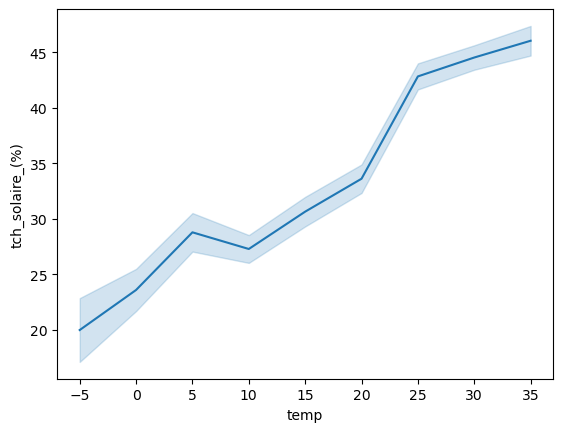

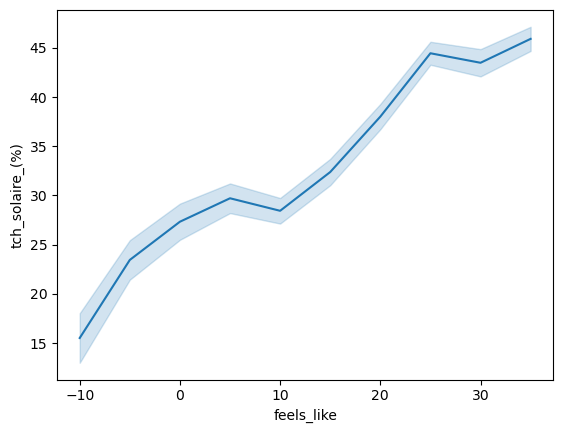

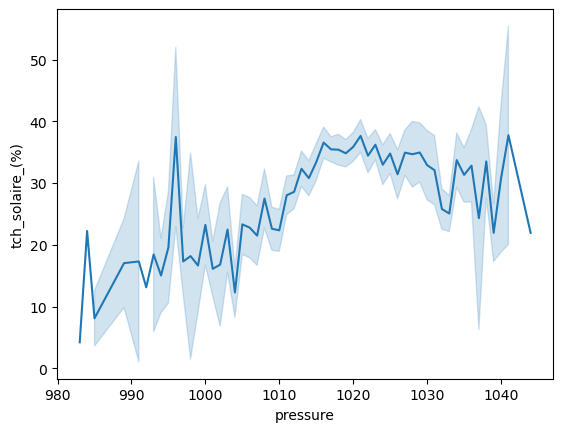

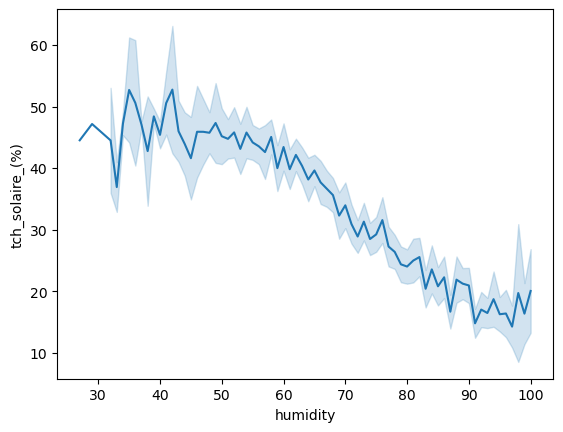

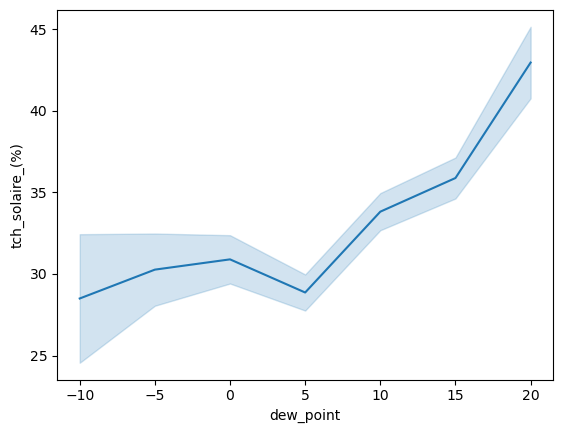

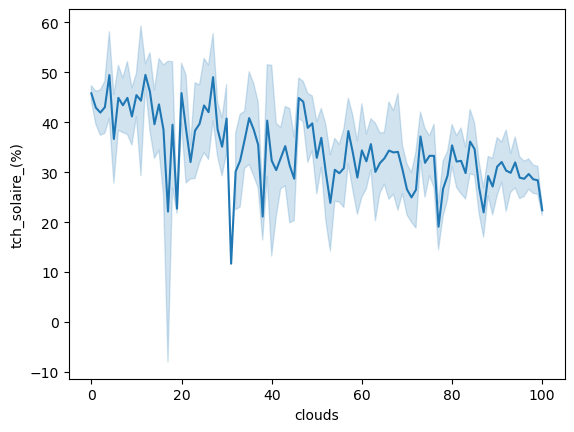

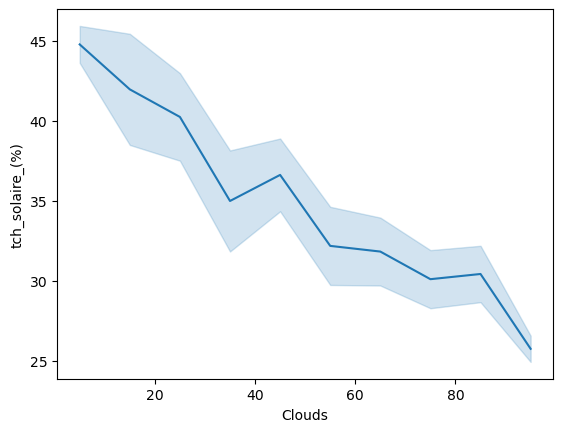

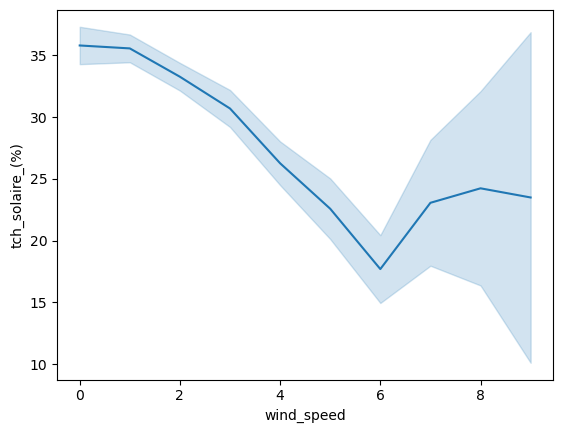

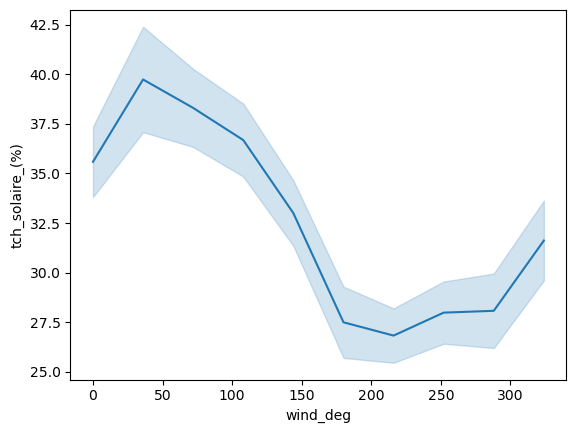

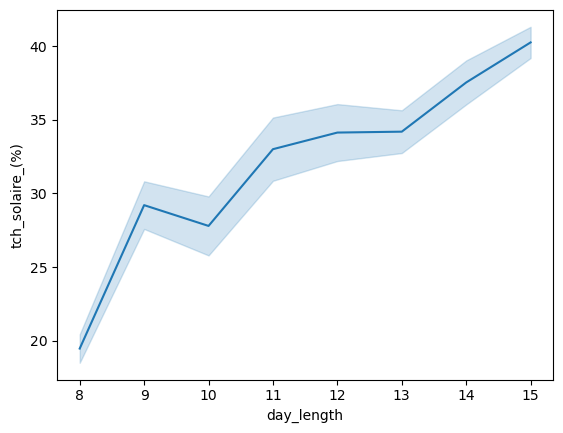

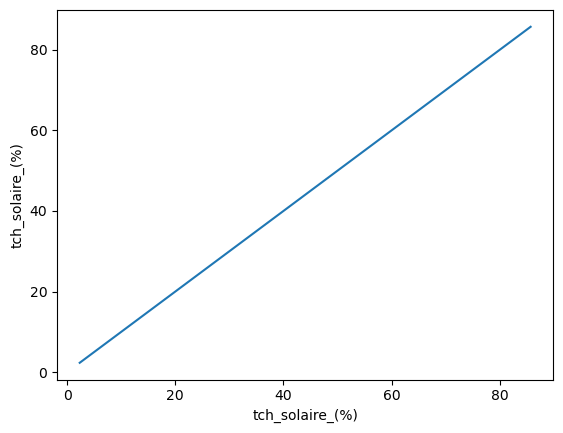

In [15]:
for feature in quantized_data.columns:    
    plt.figure()
    sns.lineplot(quantized_data, x=feature, y='tch_solaire_(%)', errorbar=('se',1.68))
    plt.show()

 - plot de chaque variable pour voir si lineaire ou si fonction "usuelle"
 - travailler sur les erreurs
 - ajouter la colonne sunset-sunrise
  - pour les colonnes rain et snow, voir si possible de faire un fillna(0)



In [ ]:
data_weather_path = 'https://renergies99-bucket.s3.eu-west-3.amazonaws.com/public/openweathermap/merge_openweathermap_cleaned.csv'
data_prod_path = 'https://renergies99-bucket.s3.eu-west-3.amazonaws.com/public/prod/eCO2mix_RTE_Auvergne-Rhone-Alpes_cleaned.csv'
features = ['temp', 'pressure', 'humidity', 'clouds'] #add sunset-sunrise
target = ['tch_solaire_(%)']


#----DATA COLLECTION--------------
collected_weather_data = mf.data_collection_weather(data_weather_path)
collected_prod_data = mf.data_collection_prod(data_prod_path)

#---DATA PREP FOR ML----
prep_data = mf.data_prep_for_ML(collected_weather_data, features) #selectionne les données qui entreront dans le modele


transformation des colonnes sunrise et sunset en format datetime
calcul de la colonne day_length (= différence des deux)


In [ ]:
weather_data = mf.data_collection_weather(data_weather_path)

In [ ]:
weather_data.columns

Index(['Moulins_dt', 'Moulins_sunrise', 'Moulins_sunset', 'Moulins_temp',
       'Moulins_feels_like', 'Moulins_pressure', 'Moulins_humidity',
       'Moulins_dew_point', 'Moulins_clouds', 'Moulins_wind_speed',
       'Moulins_wind_deg', 'Moulins_rain', 'Moulins_snow', 'Moulins_city',
       'Moulins_lat', 'Moulins_lon', 'Moulins_weather_main',
       'Moulins_weather_desc', 'Time', 'Aurillac_dt', 'Aurillac_sunrise',
       'Aurillac_sunset', 'Aurillac_temp', 'Aurillac_feels_like',
       'Aurillac_pressure', 'Aurillac_humidity', 'Aurillac_dew_point',
       'Aurillac_clouds', 'Aurillac_wind_speed', 'Aurillac_wind_deg',
       'Aurillac_rain', 'Aurillac_snow', 'Aurillac_city', 'Aurillac_lat',
       'Aurillac_lon', 'Aurillac_weather_main', 'Aurillac_weather_desc',
       'Saint-Étienne_dt', 'Saint-Étienne_sunrise', 'Saint-Étienne_sunset',
       'Saint-Étienne_temp', 'Saint-Étienne_feels_like',
       'Saint-Étienne_pressure', 'Saint-Étienne_humidity',
       'Saint-Étienne_dew_point',